In [ ]:
# https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

In [10]:
from pandas import read_csv
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

series = read_csv('daily-total-female-births-CA.csv', header=0, index_col=0)


            births
date              
1959-01-01      35
1959-01-02      32
1959-01-03      30
1959-01-04      31
1959-01-05      44


<Figure size 1440x480 with 0 Axes>

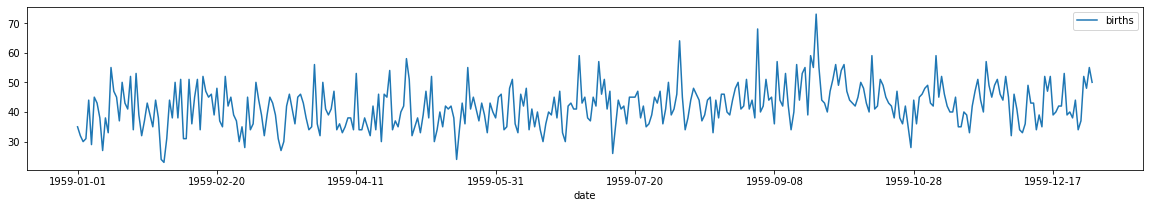

In [11]:

plt.rcParams["figure.figsize"] = (20,3)
print(series.head())
figure(figsize=(18, 6), dpi=80)
series.plot()
pyplot.show()

               births
date                 
1959-01-01        NaN
1959-01-02        NaN
1959-01-03  32.333333
1959-01-04  31.000000
1959-01-05  35.000000
1959-01-06  34.666667
1959-01-07  39.333333
1959-01-08  39.000000
1959-01-09  42.000000
1959-01-10  36.000000


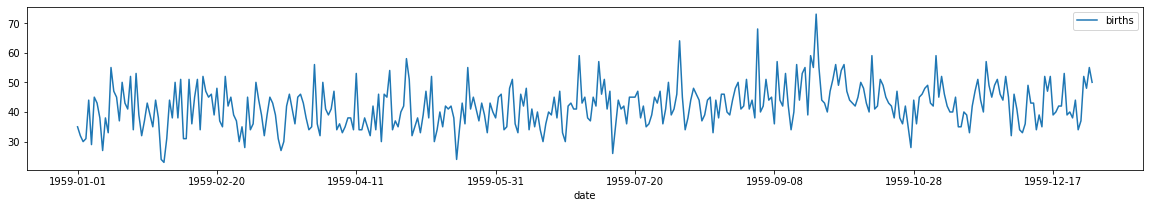

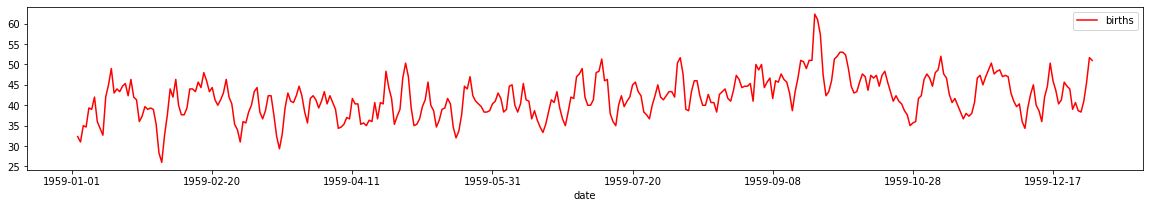

In [14]:

from pandas import read_csv
from matplotlib import pyplot
series = read_csv('daily-total-female-births-CA.csv', header=0, index_col=0)
# Tail-rolling average transform
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()

## Moving Average as Feature Engineering

In [15]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
series = read_csv('daily-total-female-births-CA.csv', header=0, index_col=0)


In [44]:
df = DataFrame(series.values)


In [45]:
df.head()

,0
0,35
1,32
2,30
3,31
4,44


In [23]:
df = DataFrame(series.values)
width = 3
lag1 = df.shift(1)
lag2= df.shift(2)
lag3 = df.shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1,lag2, df], axis=1)
dataframe.columns = ['mean', 't-1', 't+1','t+2']
print(dataframe.head(10))

        mean   t-1   t+1  t+2
0        NaN   NaN   NaN   35
1        NaN  35.0   NaN   32
2        NaN  32.0  35.0   30
3        NaN  30.0  32.0   31
4  32.333333  31.0  30.0   44
5  31.000000  44.0  31.0   29
6  35.000000  29.0  44.0   45
7  34.666667  45.0  29.0   43
8  39.333333  43.0  45.0   38
9  39.000000  38.0  43.0   27


In [24]:
######  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [25]:
## Random forest for time series prediction

In [39]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=10000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions


In [40]:
 
# load the dataset
series = read_csv('daily-total-female-births-CA.csv', header=0, index_col=0)
values = series.values


In [41]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=3)

In [42]:
data

array([[35., 32., 30., 31.],
       [32., 30., 31., 44.],
       [30., 31., 44., 29.],
       ...,
       [34., 37., 52., 48.],
       [37., 52., 48., 55.],
       [52., 48., 55., 50.]])

>expected=42.0, predicted=46.3
>expected=53.0, predicted=42.0
>expected=39.0, predicted=42.7
>expected=40.0, predicted=39.2
>expected=38.0, predicted=44.2
>expected=44.0, predicted=41.4
>expected=34.0, predicted=44.8
>expected=37.0, predicted=39.0
>expected=52.0, predicted=43.0
>expected=48.0, predicted=42.0
>expected=55.0, predicted=46.4
>expected=50.0, predicted=44.3
MAE: 5.899


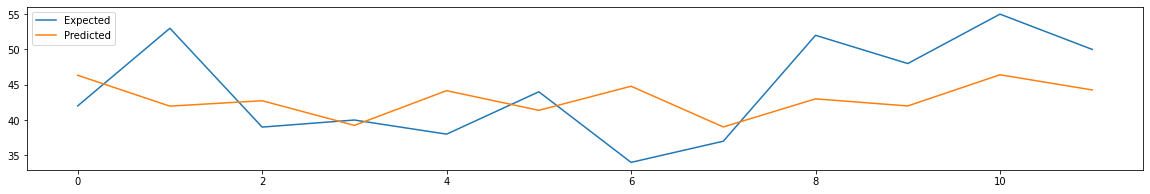

In [43]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()